# Notebook referente ao último trabalho: European Soccer Database

https://www.kaggle.com/c/talkingdata-mobile-user-demographics

## Disciplina: Mineração de Dados (Setembro/16)

## Aluno: Renato Santos Aranha

In [2]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from bokeh.plotting import figure, ColumnDataSource, show
from bokeh.models import HoverTool
from bokeh.io import output_notebook
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
output_notebook()

Loading BokehJS ...

# Agenda:
* Carregando e verificando os dados;


* Perguntas;
    * Como é a distribuição de partidas por diferença de gol?
    * Qual percentual de partidas são vencidas pelo time da casa (por país)?
    * Qual percentual de partidas são empates (por país)?
    * Jogadores de mesma posição possuem semelhança nos scouts? (T-SNE dos scouts dos jogadores)
    * Como ocorreu a evolução anual dos melhores jogadores?


## Carregando e verificando os dados:

In [3]:
#database = '/Users/Renato Aranha/Documents/Python Scripts/database.sqlite'
database = '/Users/renato.aranha/Desktop/git/MMD/database.sqlite'

In [4]:
conn = sqlite3.connect(database)

In [5]:
query = "SELECT name FROM sqlite_master WHERE type='table';"
pd.read_sql(query, conn)

,name
0,Country
1,sqlite_sequence
2,League
3,Match
4,Player
5,Player_Stats
6,Team


In [6]:
country = pd.read_sql_query("select * from Country", conn, index_col='id')
match = pd.read_sql_query("select * from Match", conn)
league = pd.read_sql_query("select * from League", conn)
team = pd.read_sql_query("select * from Team", conn)
Player = pd.read_sql("SELECT * FROM Player", conn)
Player_Stats = pd.read_sql("SELECT * FROM Player_Stats", conn)

In [7]:
country

,name
id,
1,Belgium
1729,England
4735,France
7775,Germany
10223,Italy
13240,Netherlands
15688,Poland
17608,Portugal
19660,Scotland


In [8]:
match['country_id'].unique()

array([    1,  1729,  4735,  7775, 10223, 13240, 15688, 17608, 19660,
       21484, 24524], dtype=int64)

In [9]:
match.head(3)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.0,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.2
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.8,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.6
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
league.head(3)

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4735,4735,France Ligue 1


In [11]:
team.head(3)

,id,team_api_id,team_long_name,team_short_name
0,1,9987,Genk,GEN
1,2,9993,Beerschot AC,BAC
2,3,10000,Zulte-Waregem,ZUL


In [12]:
Player.head(3)

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163


In [13]:
Player_Stats.head(3)

,id,player_fifa_api_id,player_api_id,date_stat,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0


In [14]:
Player.count()

id                    11060
player_api_id         11060
player_name           11060
player_fifa_api_id    11060
birthday              11060
height                11060
weight                11060
dtype: int64

In [16]:
match = pd.read_sql_query("select * from Match", conn)

In [17]:
match = (match.merge(country[['name']], how='left',left_on='country_id',right_on='id',right_index=True))

In [19]:
match = match.rename(columns={'name': 'país'})

In [20]:
match['país'].unique()

array(['Belgium', 'England', 'France', 'Germany', 'Italy', 'Netherlands',
       'Poland', 'Portugal', 'Scotland', 'Spain', 'Switzerland'], dtype=object)

## Perguntas:

    * Como é a distribuição de partidas por gol de diferença?


25.4 % das partidas terminam empatadas.
( 6590 em  25945 jogos).

37.0 % das partidas terminam com diferença de UM gol.
( 9587 em  25945 jogos).

22.1 % das partidas terminam com diferença de DOIS gols.
( 5728 em  25945 jogos).


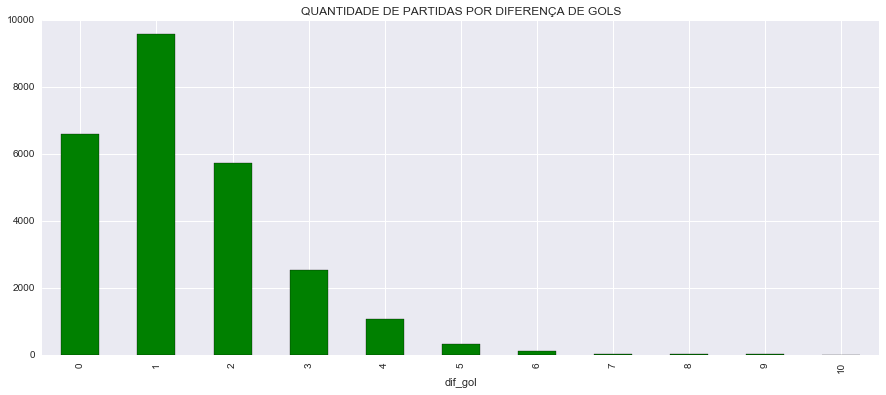

In [134]:
match['dif_gol'] = abs(pd.Series(match['home_team_goal'] - match['away_team_goal'])) #criando coluna com a diferença de gols

jogos_dif_de_gols = match.groupby(['dif_gol']).count()['match_api_id']
jogos_dif_de_gols.plot(kind='bar',figsize=(15,6),title='QUANTIDADE DE PARTIDAS POR DIFERENÇA DE GOLS', color = 'g')

empate = jogos_dif_de_gols[0];
um_gol_de_dif = jogos_dif_de_gols[1];
dois_gols_de_dif = jogos_dif_de_gols[2];
print ()
print (round(100*(empate)/match.shape[0],1), "% das partidas terminam empatadas.")
print ("(",empate,"em ",match.shape[0],"jogos).")
print ()
print (round(100*(um_gol_de_dif)/match.shape[0],1), "% das partidas terminam com diferença de UM gol.")
print ("(",um_gol_de_dif,"em ",match.shape[0],"jogos).")
print ()
print (round(100*(dois_gols_de_dif)/match.shape[0],1), "% das partidas terminam com diferença de DOIS gols.")
print ("(",dois_gols_de_dif,"em ",match.shape[0],"jogos).")

## e por país?

In [22]:
jogos_dif_de_gols_pais = match.groupby(['país','dif_gol']).count()['match_api_id']
test = pd.DataFrame(jogos_dif_de_gols_pais)
test.head()

match_api_id
país    dif_gol              
Belgium 0                 425
        1                 634
        2                 412
        3                 162
        4                  62

In [23]:
test = test.reset_index().rename(columns={'país': 'pais'})

In [24]:
test.head()

,pais,dif_gol,match_api_id
0,Belgium,0,425
1,Belgium,1,634
2,Belgium,2,412
3,Belgium,3,162
4,Belgium,4,62


In [25]:
a = test[['pais','match_api_id']].groupby('pais').sum()
a

,match_api_id
pais,
Belgium,1728
England,3006
France,3040
Germany,2448
Italy,3017
Netherlands,2448
Poland,1920
Portugal,2052
Scotland,1824


In [26]:
test = test.merge(a[['match_api_id']],how='left',left_on='pais',right_on='pais',right_index=True)

In [27]:
test.head()

,pais,dif_gol,match_api_id_x,match_api_id_y
0,Belgium,0,425,1728
1,Belgium,1,634,1728
2,Belgium,2,412,1728
3,Belgium,3,162,1728
4,Belgium,4,62,1728


In [28]:
test['percent'] = test['match_api_id_x']/test['match_api_id_y']
test = test[['pais','dif_gol','percent']]

In [135]:
match['dif_gol'] = pd.Series(match['home_team_goal'] - match['away_team_goal'])

match_casa = match[match['dif_gol']>0][['país','dif_gol','match_api_id']]
match_fora = match[match['dif_gol']<0][['país','dif_gol','match_api_id']]

print ()
print ()
print (round(100*(match_casa['match_api_id'].count())/match.shape[0],1), "% das partidas são vencidas pelo time da casa.")
print ()
print (round(100*(match_fora['match_api_id'].count())/match.shape[0],1), "% das partidas são vencidas pelo time visitante.")
print ()
partidas_por_dif_de_gols = match.groupby('dif_gol').count()['match_api_id']
print (round(100*partidas_por_dif_de_gols[0]/match.shape[0],1), "% são empates." )
print ()
print ()



45.9 % das partidas são vencidas pelo time da casa.

28.7 % das partidas são vencidas pelo time visitante.

25.4 % são empates.




In [30]:
tools = 'box_zoom, pan, save, reset'
fig = figure(tools=tools, title='DIFERENÇA DE GOLS POR PAÍS', responsive=True,
             x_axis_label='DIFERENCA DE GOLS', y_axis_label='TOTAL DE PARTIDAS (PERCENTUAL)')

source = ColumnDataSource(test)
hover = HoverTool()
hover.tooltips=[('pais','@pais')]
fig.scatter(test['dif_gol'], test['percent'], source=source, size=20, alpha=1, line_color='black', fill_color='blue')

fig.add_tools(hover)

show(fig)

## Perguntas:

    * Qual percentual de partidas são empates (e por país)?

In [31]:
a = pd.DataFrame(match.groupby(['país','dif_gol']).count()['match_api_id']).reset_index()
b = pd.DataFrame(match.groupby(['país']).count()['match_api_id'])

In [32]:
a.head(2)

,país,dif_gol,match_api_id
0,Belgium,-6,4
1,Belgium,-5,3


In [33]:
novo = a.merge(b[['match_api_id']], how='left',left_on='país',right_on='país',right_index=True)


Países com MAIOR incidência de empates: France e Poland

Países com MENOR incidência de empates: Spain e Netherlands



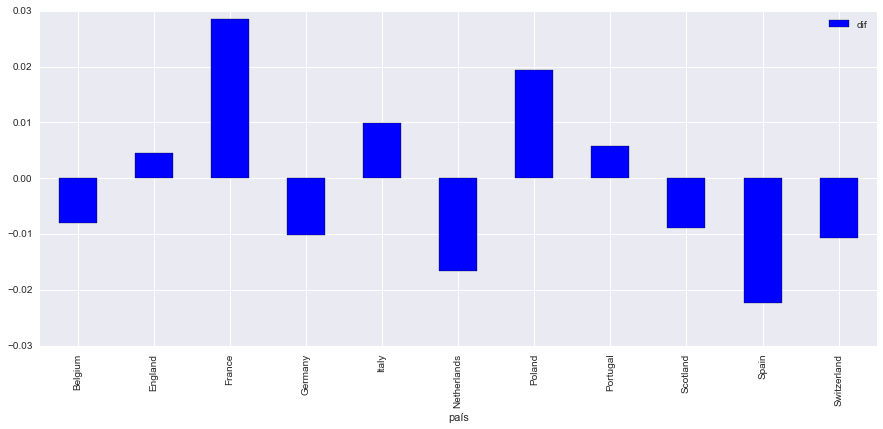

In [34]:
novo['percent']=novo['match_api_id_x']/novo['match_api_id_y']
graf = novo[novo['dif_gol']==0][['país','percent']]
graf['dif'] = graf['percent']-0.254 #0,254 é o percentual total de empates em todas as ligas (aqui estou pegando os desvios)
graf.plot(kind='bar',figsize=(15,6), color = 'b', x='país',y='dif')
print()
print("Países com MAIOR incidência de empates: France e Poland")
print()
print("Países com MENOR incidência de empates: Spain e Netherlands")
print()

In [35]:
graf

,país,percent,dif
6,Belgium,0.245949,-0.008051
20,England,0.258483,0.004483
35,France,0.282566,0.028566
49,Germany,0.243873,-0.010127
64,Italy,0.263838,0.009838
78,Netherlands,0.237337,-0.016663
93,Poland,0.273438,0.019437
106,Portugal,0.259747,0.005747
120,Scotland,0.245066,-0.008934
137,Spain,0.231579,-0.022421


## T-SNE dos scouts dos jogadores:
https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding

In [36]:
query = """SELECT * FROM Player_Stats a
           INNER JOIN (SELECT player_name, player_api_id AS p_id FROM Player) b ON a.player_api_id = b.p_id;"""

drop_cols = ['id','player_fifa_api_id','date_stat','preferred_foot','attacking_work_rate','defensive_work_rate']

players = pd.read_sql(query, conn)
players['date_stat'] = pd.to_datetime(players['date_stat'])
players = players[players.date_stat > pd.datetime(2015,1,1)]
players = players[~players.overall_rating.isnull()].sort_values('date_stat', ascending=False)
players = players.drop_duplicates(subset='player_api_id', keep='first')
players = players.drop(drop_cols, axis=1)

players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7676 entries, 1312 to 76345
Data columns (total 38 columns):
player_api_id         7676 non-null int64
overall_rating        7676 non-null float64
potential             7676 non-null float64
crossing              7676 non-null float64
finishing             7676 non-null float64
heading_accuracy      7676 non-null float64
short_passing         7676 non-null float64
volleys               7676 non-null float64
dribbling             7676 non-null float64
curve                 7676 non-null float64
free_kick_accuracy    7676 non-null float64
long_passing          7676 non-null float64
ball_control          7676 non-null float64
acceleration          7676 non-null float64
sprint_speed          7676 non-null float64
agility               7676 non-null float64
reactions             7676 non-null float64
balance               7676 non-null float64
shot_power            7676 non-null float64
jumping               7676 non-null float64
stamina    

In [37]:
players = players.fillna(0)

cols = ['player_api_id','player_name','overall_rating','potential']
stats_cols = [col for col in players.columns if col not in (cols)]

In [38]:
ss = StandardScaler()
tmp = ss.fit_transform(players[stats_cols])
model = TSNE(n_components=2, random_state=0)
tsne_comp = model.fit_transform(tmp)

In [12]:
tmp = players[cols]
tmp['comp1'], tmp['comp2'] = tsne_comp[:,0], tsne_comp[:,1]
tmp = tmp[tmp.overall_rating >= 80]

tools = 'box_zoom, pan, save, reset'
fig = figure(tools=tools, title='t-SNE', responsive=True,
             x_axis_label='Component 1', y_axis_label='Component 2')

source = ColumnDataSource(tmp)
hover = HoverTool()
hover.tooltips=[('atleta','@player_name')]
fig.scatter(tmp['comp1'], tmp['comp2'], source=source, size=10, alpha=1, line_color='blue', fill_color='blue')

fig.add_tools(hover)

show(fig)

C:\Users\renato.aranha\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


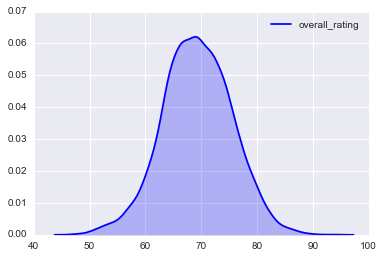

In [39]:
sns.kdeplot(players.overall_rating, shade=True, color="b")

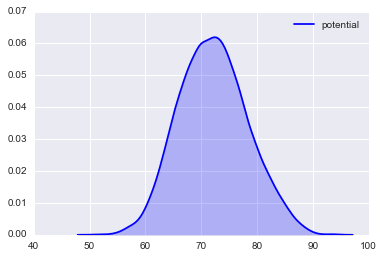

In [40]:
sns.kdeplot(players.potential, shade=True, color="b")

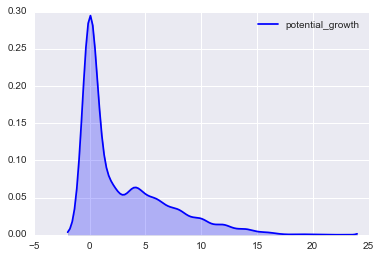

In [41]:
players['potential_growth'] = players.potential - players.overall_rating
sns.kdeplot(players.potential_growth, shade=True, color="b")

In [46]:
players[['player_name','potential_growth']].sort('potential_growth',ascending=False).head(10)

C:\Users\renato.aranha\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,player_name,potential_growth
172154,Tom Davies,22.0
68655,Harry Souttar,20.0
146698,Reece Oxford,20.0
98200,Kylian Mbappe Lottin,20.0
76538,Jan Bamert,19.0
54889,Felix Passlack,19.0
85512,Jonathan Leko,19.0
92541,Kamil Jozwiak,19.0
158105,Sean McKirdy,19.0
161823,Silvan Hefti,19.0


In [152]:
players = players.sort_values('overall_rating', ascending=False)
best_players = players[['player_api_id','player_name']].head(15)
ids = tuple(best_players.player_api_id.unique())

query = '''SELECT player_api_id, date_stat, overall_rating, potential
           FROM Player_Stats WHERE player_api_id in %s''' % (ids,)

evolution = pd.read_sql(query, conn)
evolution = pd.merge(evolution, best_players)
evolution['year'] = evolution.date_stat.str[:4].apply(int)
evolution = evolution.groupby(['year','player_api_id','player_name']).overall_rating.mean()
evolution = evolution.reset_index()

evolution.sort_values('overall_rating', ascending=False).head(15)
#best_players

,year,player_api_id,player_name,overall_rating
93,2013,30981,Lionel Messi,94.000000
78,2012,30981,Lionel Messi,94.000000
123,2015,30981,Lionel Messi,93.428571
108,2014,30981,Lionel Messi,93.333333
121,2015,30893,Cristiano Ronaldo,92.600000
91,2013,30893,Cristiano Ronaldo,92.000000
106,2014,30893,Cristiano Ronaldo,92.000000
63,2011,30981,Lionel Messi,92.000000
76,2012,30893,Cristiano Ronaldo,92.000000
17,2008,30893,Cristiano Ronaldo,91.000000


,player_api_id,player_name
101978,30981,Lionel Messi
33156,30893,Cristiano Ronaldo
130834,19533,Neymar
105468,40636,Luis Suarez
108509,27299,Manuel Neuer
16383,30834,Arjen Robben
182801,35724,Zlatan Ibrahimovic
12717,30955,Andres Iniesta
121856,36378,Mesut Oezil
47010,107417,Eden Hazard


Evolução dos melhores jogadores:

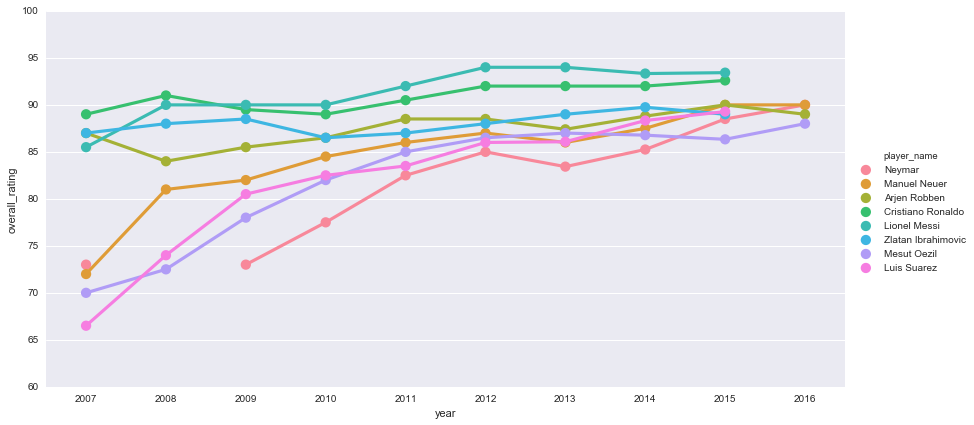

In [153]:
a = sns.factorplot(data=evolution[evolution.player_api_id.isin(ids[0:8])], x='year',
                   y='overall_rating', hue='player_name', size=6, aspect=2,kind='point',orient='v',legend_out=True)

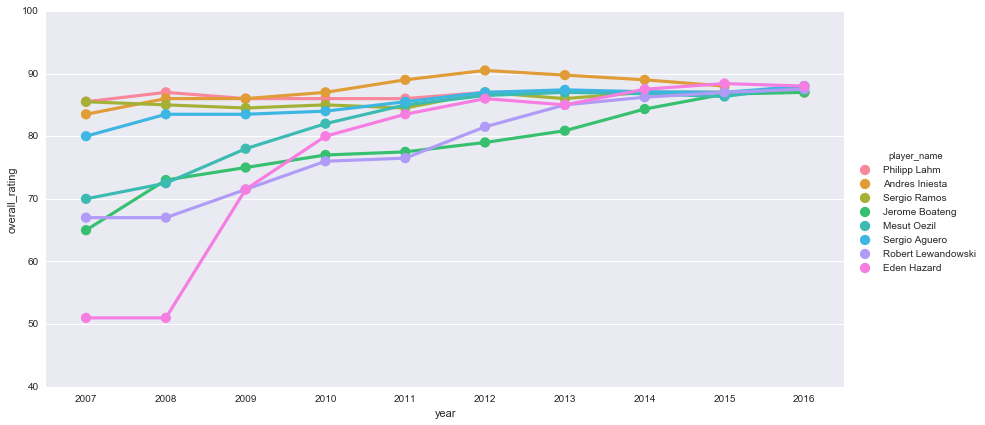

In [124]:
a = sns.factorplot(data=evolution[evolution.player_api_id.isin(ids[8:16])], x='year',
                   y='overall_rating', hue='player_name', size=6, aspect=2,kind='point',orient='v',legend_out=True)

In [112]:
Player['ano_nasc'] = Player.birthday.str[:4].apply(int)
Player['idade'] = 2016 - Player['ano_nasc']
Player['idade_em_2007'] = 2007 - Player['ano_nasc']
Player.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,ano_nasc,idade,idade_em_2007
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,1992,24,15
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146,1989,27,18
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163,1991,25,16
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198,1982,34,25
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154,1979,37,28


Evolução dos melhores jogadores (tentativa de abertura por idade):

In [65]:
tmp = players[cols]
tmp['comp1'], tmp['comp2'] = tsne_comp[:,0], tsne_comp[:,1]
tmp['potential_growth'] = tmp.potential - tmp.overall_rating
tmp = tmp[(tmp.potential_growth >= 5) & (tmp.overall_rating >= 75)]

_tools = 'box_zoom,pan,save,resize,reset,tap,wheel_zoom'
fig = figure(tools=_tools, title='t-SNE of Potential Top Players (FIFA stats)', responsive=True,
             x_axis_label='Component 1', y_axis_label='Component 2')

source = ColumnDataSource(tmp)
hover = HoverTool()
hover.tooltips=[('Jogador','@player_name'),]
fig.scatter(tmp['comp1'], tmp['comp2'], source=source, size=10, alpha=1,
            line_color='blue', fill_color='blue')

fig.add_tools(hover)

show(fig)

C:\Users\renato.aranha\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\renato.aranha\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [113]:
renato = pd.merge(evolution, Player).sort_values('idade_em_2007', ascending=True)
renato.head()

,year,player_api_id,player_name,overall_rating,id,player_fifa_api_id,birthday,height,weight,ano_nasc,idade,idade_em_2007
0,2007,19533,Neymar,73.0,7863,190871,1992-02-05 00:00:00,175.26,150,1992,24,15
1,2009,19533,Neymar,73.0,7863,190871,1992-02-05 00:00:00,175.26,150,1992,24,15
2,2010,19533,Neymar,77.5,7863,190871,1992-02-05 00:00:00,175.26,150,1992,24,15
3,2011,19533,Neymar,82.5,7863,190871,1992-02-05 00:00:00,175.26,150,1992,24,15
4,2012,19533,Neymar,85.0,7863,190871,1992-02-05 00:00:00,175.26,150,1992,24,15


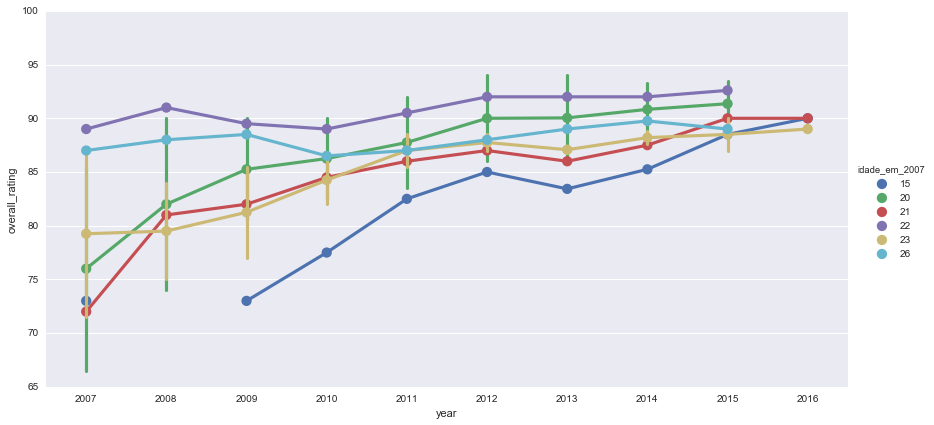

In [123]:
a = sns.factorplot(data=renato[renato.player_api_id.isin(ids[0:8])], x='year',
                   y='overall_rating', hue='idade_em_2007', size=6, aspect=2,kind='point',orient='v',legend_out=True)